# Cosmological Analysis

###  Renée Hložek and Jeff McMahon

We are going to do a very rough example of an MCMC, using the <a href=" https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm"> Metroplis Hastings algorithm. </a>


We will start by pulling CAMB python so that we can get it running. Get pycamb from https://pypi.python.org/pypi/camb/0.1.1.

In [1]:
import os
import sys
import platform
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import camb
from camb import model, initialpower

In [3]:
data = './data/'
out = './output/'

### Just some matplotlib and seaborn parameter tuning

In [4]:
axistitlesize = 20
axisticksize = 15
axislabelsize = 23
axislegendsize = 13
axistextsize = 20
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')

## I. Set initial parameters for CAMB and calculate cosmology

In [5]:
# We will start by pulling initialising the CAMB params structure that we will use later

# Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
# The base cosmology model is set with these params, the others are all set to their default values
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
# The initial power spectrum is set here, separately from the rest of cosmology
pars.InitPower.set_params(ns=0.965, r=0)

# Set how far in multipole we want the power spectra, and turn on defaults for the params
pars.set_for_lmax(4400, lens_potential_accuracy=0);

# Calculate results for these parameters 
# This is like "running" CAMB from the command line, and is the same as how it is done in CosmoMC
results = camb.get_results(pars)

# Get dictionary of CAMB power spectra
powers = results.get_cmb_power_spectra(pars)

In [6]:
# Let's see what the power spectra are:
for name in powers: print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


In [7]:
# Now we want to plot the total lensed and unlensed CMB power spectra
CMBOutscale = 7.43e12
totCL = powers['total']
unlensedCL = powers['unlensed_scalar']
# Note L = 0,1 entries will be zero by default.
# The different Cls are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
ls = np.arange(totCL.shape[0])

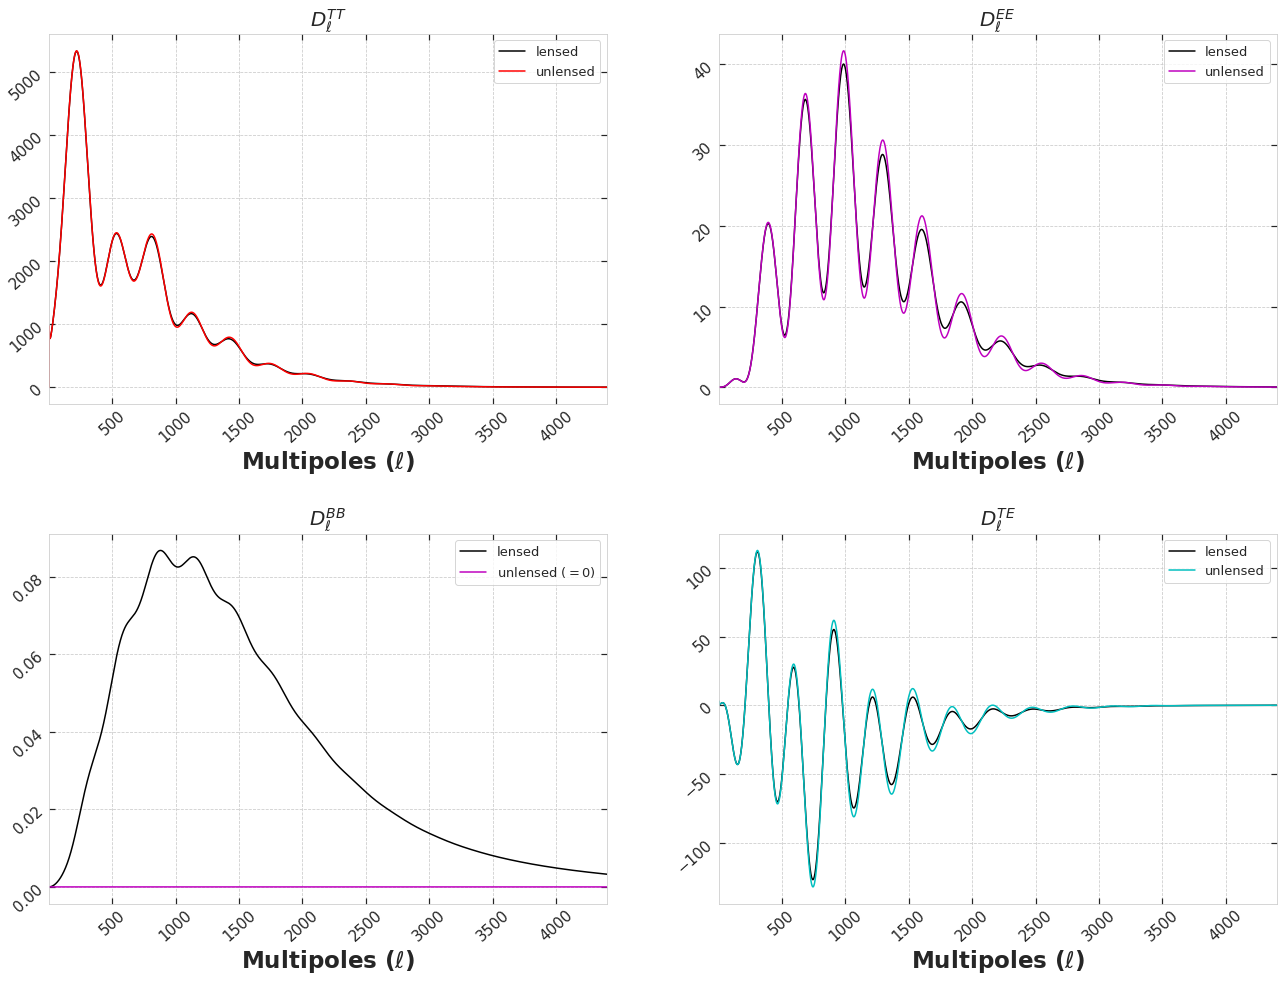

In [8]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize = (ncols*11, nrows*8))
fig.subplots_adjust(hspace=0.35)

# I. ClTT
ax = axes[0][0]
ax.plot(ls, CMBOutscale*totCL[:,0], color='k', label='lensed')
ax.plot(ls, CMBOutscale*unlensedCL[:,0], color='r', label='unlensed')
ax.legend(loc="upper right", fontsize=axislegendsize)
ax.set_title('$D_{\ell}^{TT}$', fontsize=axistitlesize)

# II. ClEE
ax = axes[0][1]
ax.plot(ls, CMBOutscale*totCL[:,1], color='k', label='lensed')
ax.plot(ls, CMBOutscale*unlensedCL[:,1], color='m', label='unlensed')
ax.legend(loc="upper right", fontsize=axislegendsize)
ax.set_title('$D_{\ell}^{EE}$', fontsize=axistitlesize)

# III. ClBB
ax = axes[1][0]
ax.plot(ls, CMBOutscale*totCL[:,2], color='k', label='lensed')
ax.plot(ls, CMBOutscale*unlensedCL[:,2], color='m', label='unlensed ($=0$)')
ax.legend(loc="upper right", fontsize=axislegendsize)
ax.set_title('$D_{\ell}^{BB}$', fontsize=axistitlesize)

# IV. ClTE
ax = axes[1][1]
ax.plot(ls,CMBOutscale*totCL[:,3], color='k', label='lensed')
ax.plot(ls,CMBOutscale*unlensedCL[:,3], color='c', label='unlensed')
ax.legend(loc="upper right", fontsize=axislegendsize)
ax.set_title('$D_{\ell}^{TE}$', fontsize=axistitlesize);

for ax in axes.reshape(-1):
    ax.set_xlim(2,4400)
    ax.set_xlabel('Multipoles ($\ell$)', fontsize=axislabelsize, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=axisticksize,
                   labelrotation=42)

### Compute the $C_{\ell}^{BB}$s over a range of parameters

In [11]:
# You can calculate spectra for different primordial power spectra without recalculating everything
# for example, let's plot the BB mode the CMB spectra as a function of r
pars.WantTensors = True
results = camb.get_transfer_functions(pars)

rs = np.linspace(0,0.2,6)

lmax = 2000
ell = np.arange(lmax+1)

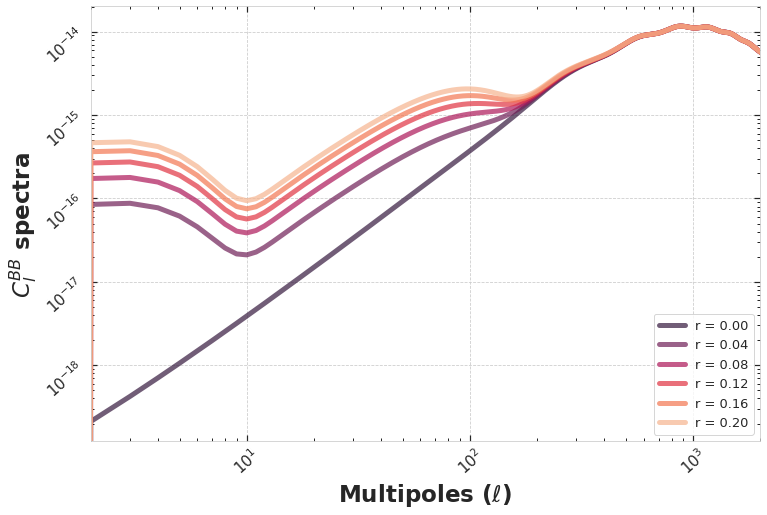

In [12]:
fig, axes = plt.subplots(figsize=(12,8))
for r in rs:
    inflation_params = initialpower.InitialPowerLaw()
    inflation_params.set_params(ns=0.96, r=r)
    results.power_spectra_from_transfer(inflation_params)
    cl = results.get_total_cls(lmax)
    axes.loglog(ell, cl[:,2], label='r = {0:.2f}'.format(r),
                lw=5, alpha=0.7)
axes.set_xlim(2,lmax)

axes.set_xlabel('Multipoles ($\ell$)', fontsize=axislabelsize, fontweight='bold')
axes.set_ylabel('$C_{l}^{BB}$ spectra', fontsize=axislabelsize, fontweight='bold')
axes.tick_params(axis='both', which='major', labelsize=axisticksize,
                 labelrotation=42)

axes.legend( loc='lower right', fontsize=axislegendsize);

plt.show()

## Fake likelihood for CMB S4 TT data

<font color="red">NOTE</font>: This is super simplified, in general we have a much more complicated likelihood, and any other spectra will be correlated.

In [13]:
bin_data = np.genfromtxt(data + 'binned_errors.dat')

In [14]:
# Fake likelihood based on realistic high-ell noise for CMB S4 data 
def s4_tt_likelihood(model):
    model_TT = np.zeros(len(bin_data[0]))
    indeces = np.array(bin_data[0] - 0.5, dtype='int')
    for i, idx in enumerate(indeces):
        model_TT[i] = model[idx]
    
    loglike = (bin_data[1] - model_TT)**2/(2 * bin_data[2]**2)
    loglike =- np.sum(loglike, axis=0)
    return loglike

In [15]:
# Let's call the module for the spectrum we have above.
model = totCL
ClTT = totCL[:,0]*CMBOutscale
loglike = s4_tt_likelihood(ClTT)
print(loglike)

-4023.9795543954683


## Computing log-likelihood

We are now going to call CAMB with a param vector in the same way as above, and compute the log-likelihood for this.

In [16]:
# Specify the parameters for CAMB
params = np.array([
    67.5,    # Hubble constant (H_{0}) [(km/s)/Mpc]
    0.022,   # Physical baryon density parameter (\Omega_{b} h^{2}) [dim.less]
    0.122,   # Physical dark matter density parameter (\Omega_{c} h^{2}) [dim.less]
    0,       # Curvature parameter (\Omega_{k}) [dim.less]
    0.06,    # Reionization optical depth (\tau) [dim.less]
    0.965    # Scalar spectral index (n_{s}) [dim.less]
])

In [17]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=params[0], ombh2=params[1], omch2=params[2], omk=params[3], mnu=0.06, tau=params[4])
pars.InitPower.set_params(ns=params[5], r=0)
pars.set_for_lmax(4400, lens_potential_accuracy=0);

#calculate results for these parameters
results = camb.get_results(pars)

#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars)
totCL=powers['total']
model = totCL
cltt = totCL[:,0]*CMBOutscale
loglike = s4_tt_likelihood(cltt)
print(loglike)

-4023.9795543954683


## MCMC
We are now ready to do the MCMC. We'll define the simplest/ugliest version of the Metropolis Hastings algorithm:

In [18]:
import pandas as pd

In [19]:
def mcmc_mh(ratln):
    accept=False
    r1 = np.random.rand()
    # If the step is definitely better, we want to accept it.
    # If it isn't necessarily better, we want to throw a random number and step if we exceed it
    if np.exp(ratln) > r1:
        accept=True
    return accept

In [20]:
# Using this code above, we can take a Gaussian step specified by the step vector below
stepvec = np.array([0.1,0.0001, 0.0001, 0, 0.005, 0.001])
lmax = 4400
steps = 1000                                  # Number of steps for the MCMC
loglike = np.zeros(steps)                     # Log-likelihood values
stepskeep = np.zeros((steps, len(params)))    # Kept steps

for i in range(steps):
    # First step of the MCMC
    if i==0:
        # Initialize the first step with the input parameter vector
        step = params
        pars = camb.CAMBparams()
        
        # Put the initial parameter vector into the CAMB structure
        pars.set_cosmology(H0=step[0], ombh2=step[1], omch2=step[2], omk=step[3], mnu=0.06, tau=step[4])
        pars.InitPower.set_params(ns=step[5], r=0)
        pars.set_for_lmax(lmax, lens_potential_accuracy=0)
        
        # Compute the power spectrum
        powers = results.get_cmb_power_spectra(pars)
        totCL = powers['total']
        ClTT = totCL[:,0]*CMBOutscale
        
        # Compute the likelihood
        LL = s4_tt_likelihood(ClTT)
        
        # Always accept the first, initializing step
        accept = True
        
    # Other steps
    else:
        # Add a Gaussian step to the parameter vector
        step = stepskeep[i-1] + np.random.randn(len(params)) * stepvec
        pars = camb.CAMBparams()
        
        # Put the updated parameter vector into the CAMB structure
        pars.set_cosmology(H0=step[0], ombh2=step[1], omch2=step[2], omk=step[3], mnu=0.06, tau=step[4])
        pars.InitPower.set_params(ns=step[5], r=0)
        pars.set_for_lmax(lmax, lens_potential_accuracy=0)
        
        # Compute the power spectrum
        powers = results.get_cmb_power_spectra(pars)
        totCL = powers['total']
        ClTT = totCL[:,0]*CMBOutscale
        
        # Compute the likelihood
        LL = s4_tt_likelihood(ClTT)
        rat = LL - loglike[i-1]
        
        # Test acceptance of MCMC
        accept = mcmc_mh(rat)
        
    if accept:   
        stepskeep[i] = step
        loglike[i] = LL
    else:
        stepskeep[i] = stepskeep[i-1]
        loglike[i] = loglike[i-1]
        
# Create a DataFrame of the created dataset and save to a csv
df = pd.DataFrame(data=np.c_[stepskeep, loglike],
                  columns=[
                      'H0',
                      'ombh2',
                      'omch2',
                      'omk',
                      'tau',
                      'ns',
                      'loglike'
                  ])
df.to_csv(data + 'chain.csv', index=False)

In [21]:
# Read in the chain and LL
df = pd.read_csv(data + 'chain.csv')

In [22]:
def is_left(j):
    return True if j==0 else False

In [23]:
def is_bottom(i):
    return True if i==(nrows-1) else False

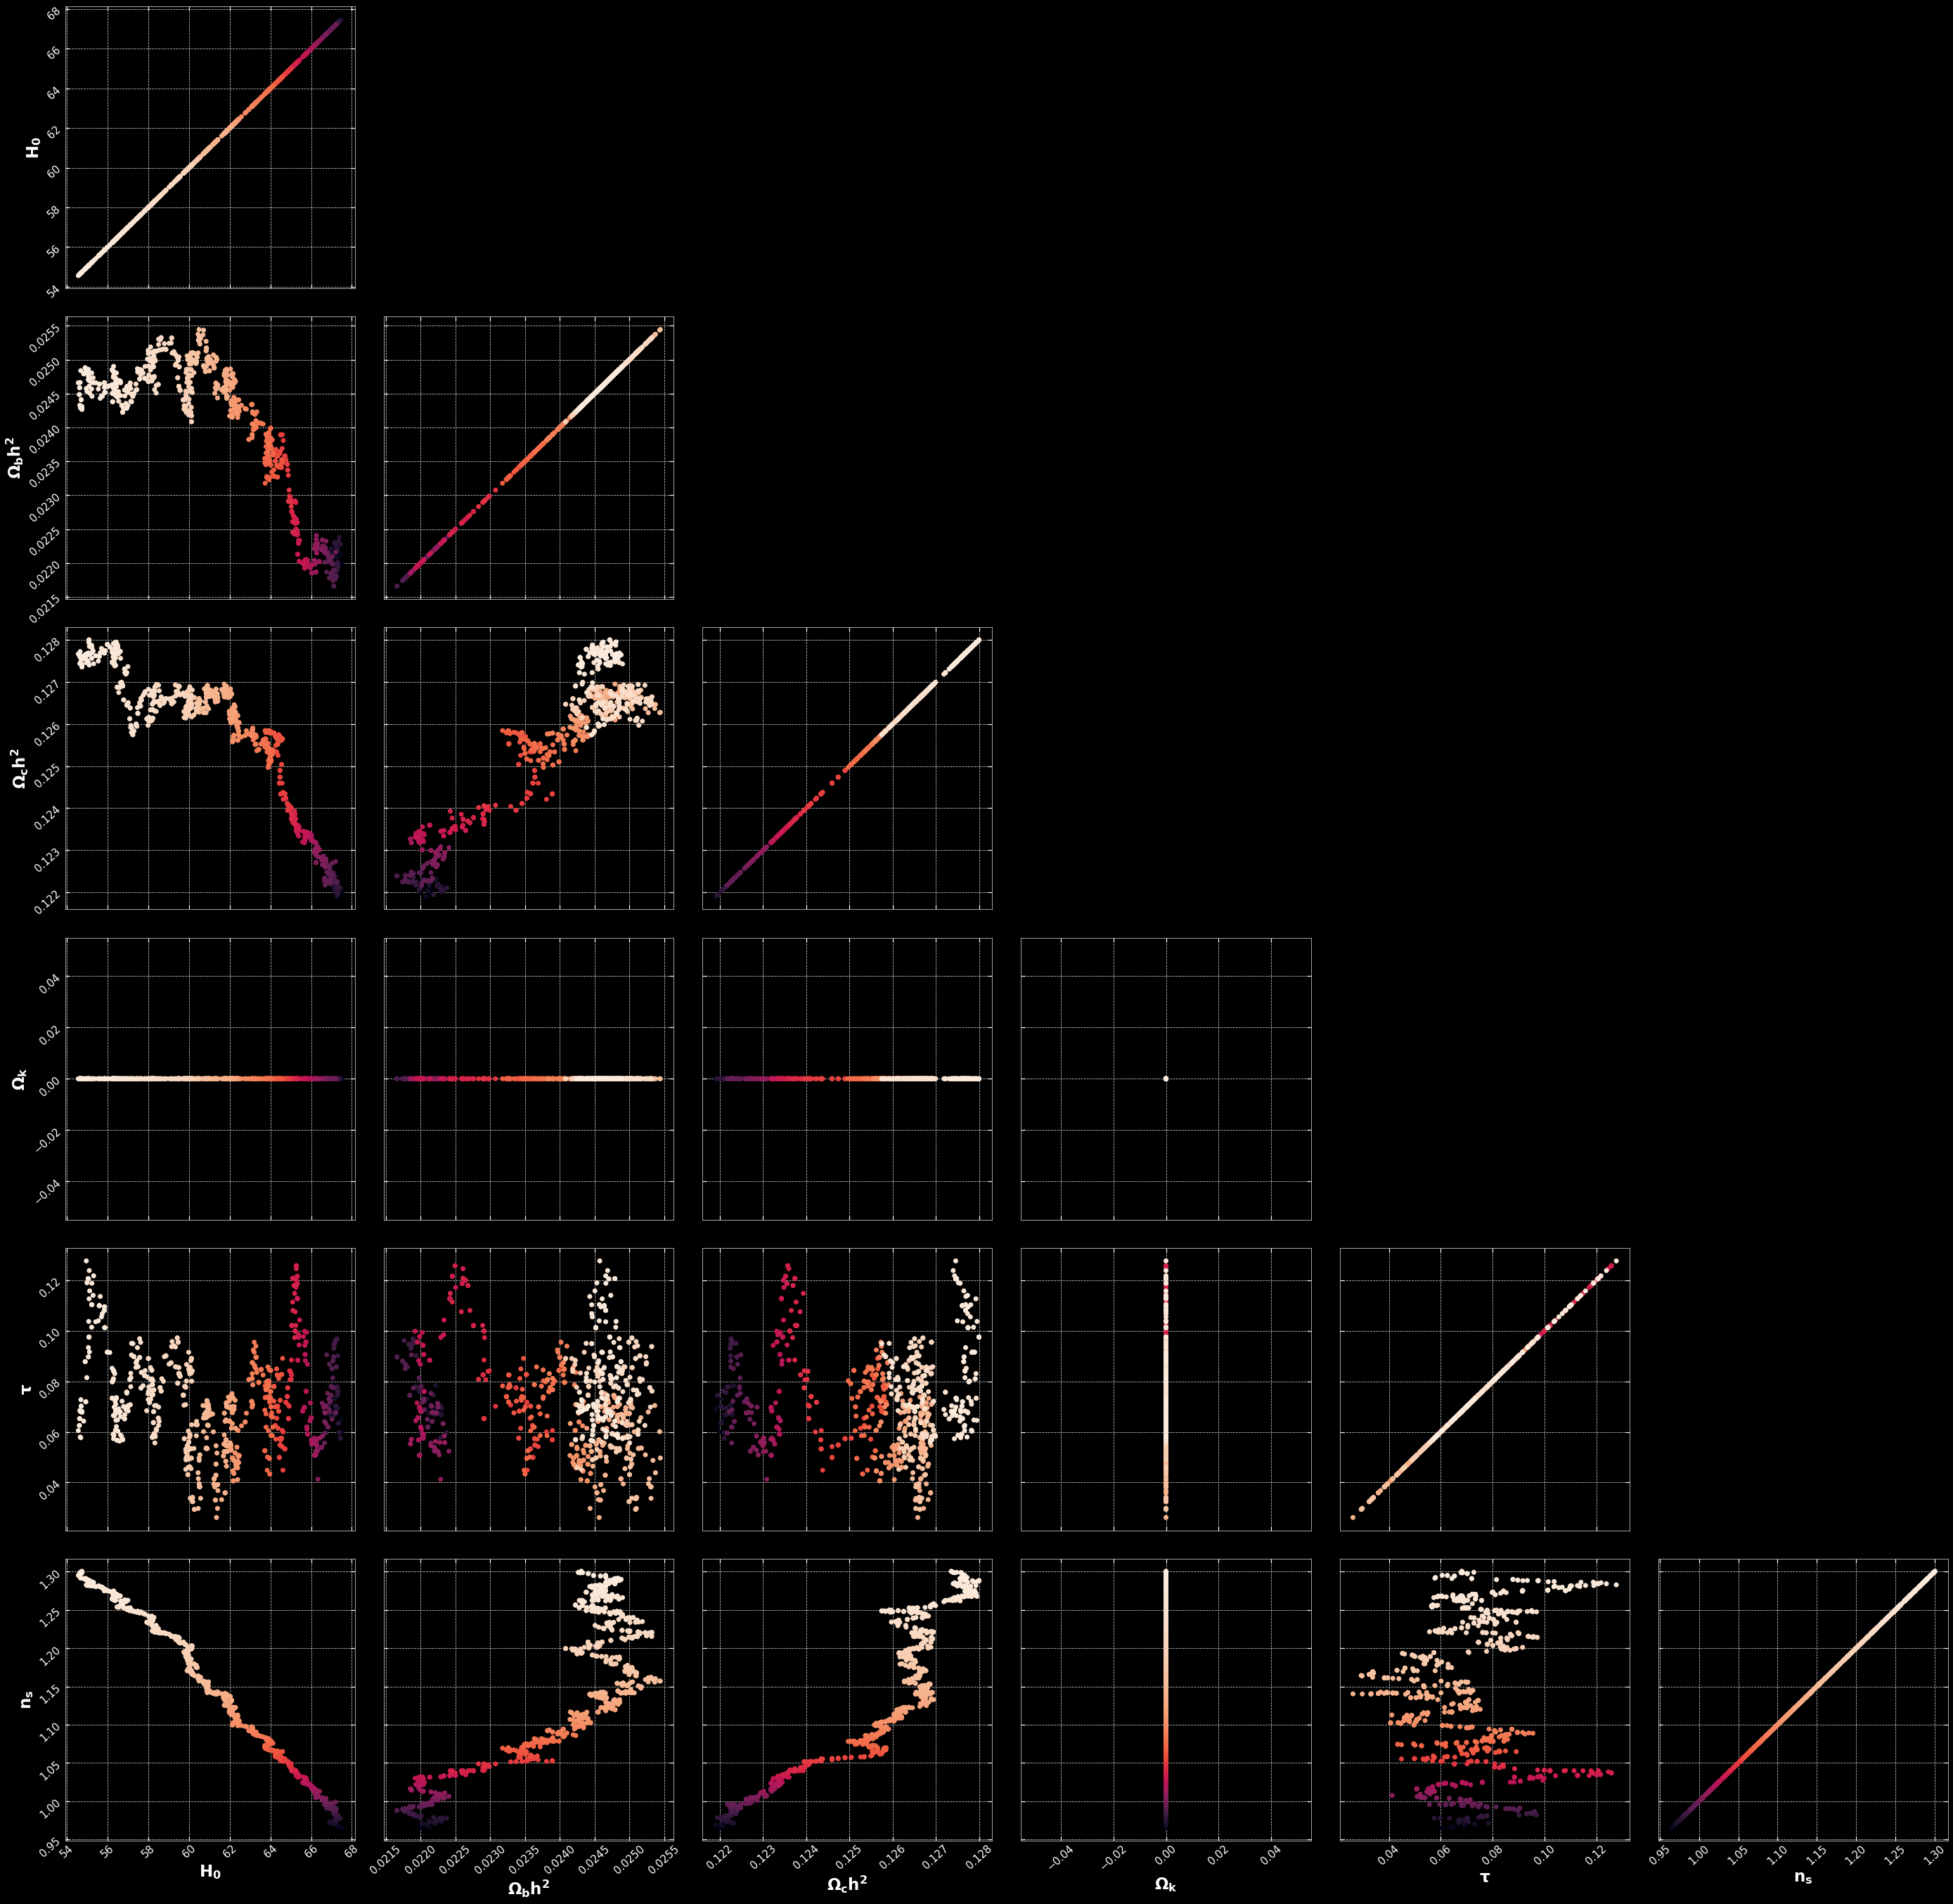

In [24]:
# Last column is the log-likelihood
columns = df.columns
nrows = len(columns) - 1# - 1
ncols = len(columns) - 1# - 1
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*8, nrows*8),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})
fig.subplots_adjust(hspace=0.1, wspace=0.1)

labels = [
    '$\mathbf{H_{0}}$',
    '$\mathbf{\Omega_{b} h^{2}}$',
    '$\mathbf{\Omega_{c} h^{2}}$',
    '$\mathbf{\Omega_{k}}$',
    '$\mathbf{\\tau}$',
    '$\mathbf{n_{s}}$'
]
for i in range(nrows):
    for j in range(ncols):
        ax = axes[i][j]
        if i >= j:
            ax.scatter(df[columns[j]], df[columns[i]],
                       c=df[columns[-1]])
            if is_bottom(i): ax.set_xlabel(labels[j], fontsize=axislabelsize, color='white')
            if is_left(j): ax.set_ylabel(labels[i], fontsize=axislabelsize, color='white')
            if not is_bottom(i): ax.set_xticklabels([])
            if not is_left(j): ax.set_yticklabels([])
            ax.tick_params(axis='both', which='major', labelsize=axisticksize,
                           labelrotation=42, colors='white')
        else: ax.axis('off')

plt.show()

In [25]:
print('Most probable parameters for the LCDM are:')
df.iloc[-1]

Most probable parameters for the LCDM are:


H0          54.732394
ombh2        0.024310
omch2        0.127357
omk          0.000000
tau          0.068132
ns           1.300492
loglike   -141.942960
Name: 999, dtype: float64

### Create another parameter space

In [22]:
# Specify the parameters for CAMB
params = np.array([
    67.32,   # Hubble constant (H_{0}) [(km/s)/Mpc]
    0.022,   # Physical baryon density parameter (\Omega_{b} h^{2}) [dim.less]
    0.120,   # Physical dark matter density parameter (\Omega_{c} h^{2}) [dim.less]
    0,       # Curvature parameter (\Omega_{k}) [dim.less]
    0.054,   # Reionization optical depth (\tau) [dim.less]
    0.966    # Scalar spectral index (n_{s}) [dim.less]
])

In [34]:
# Vary Omega_b h^2 and n_s
N = 20
omegabs = np.linspace(0.01, 0.03, N)
omegacs = np.linspace(0.08, 0.24, N)
X, Y = np.meshgrid(omegabs, omegacs)

LLs = np.zeros_like(X)

In [32]:
for i in range(N):
    for j in range(N):
        # Initialize the first step with the input parameter vector
        pars = camb.CAMBparams()
        x = X[i][j]
        y = Y[i][j]
        # Put the initial parameter vector into the CAMB structure
        pars.set_cosmology(H0=params[0], ombh2=x, omch2=y, omk=params[3], mnu=0.06, tau=params[4])
        pars.InitPower.set_params(ns=params[5], r=0)
        pars.set_for_lmax(lmax, lens_potential_accuracy=0)

        # Compute the power spectrum
        powers = results.get_cmb_power_spectra(pars)
        totCL = powers['total']
        ClTT = totCL[:,0]*CMBOutscale

        # Compute the likelihood
        LLs[i][j] = s4_tt_likelihood(ClTT)

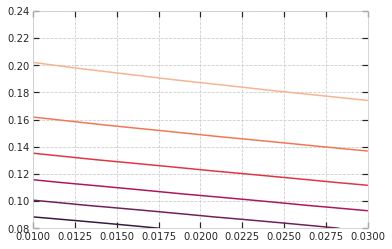

In [33]:
plt.contour(X, Y, LLs)

In [255]:
print('Most probable parameters for the LCDM are:')
df.iloc[-1]

Most probable parameters for the LCDM are:


H0           68.377749
ombh2         0.022697
omch2         0.121559
omk           0.000000
tau           0.135538
ns            1.009325
loglike   -2788.198872
Name: 99, dtype: float64

In [40]:
d = np.genfromtxt(data + 'CMB_fiducial_totalCls.dat')
ell = d[:,0]
DlTT = d[:,1]
# Convert Dl to Cl
ClTT = DlTT * 2 * np.pi / (ell * (ell + 1))

In [45]:
pars = camb.CAMBparams()
# Put the updated parameter vector into the CAMB structure
pars.set_initial_power_table(k=ell, pk=ClTT)

ArgumentError: argument 3: <class 'TypeError'>: array must have flags ['C_CONTIGUOUS']